依据The Annotated Transformer的代码进行复现

In [2]:
# 导入必要的库
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
torch.cuda.is_available()

True

In [12]:
import numpy as np 
data = np.array([[1, 2], [5, 4], [2, 3], [5, 2]])
cov = np.cov(data.T)
eig_vals, eig_vecs = np.linalg.eig(cov)
eig_vals, eig_vecs
idxs = np.argsort(eig_vals)[::-1]
topfeat = 1
select_vecs = eig_vecs[:, idxs[:topfeat]]
low_Data = np.dot(data, select_vecs)
# 数据重构
reconData = (low_Data * select_vecs.T) + np.mean(data, axis=0)
reconData

array([[4.61632543, 3.04326083],
       [8.85053312, 3.95206868],
       [5.77746852, 3.29248242],
       [8.44016844, 3.86399019]])

# 嵌入层

In [30]:
class Embedding(nn.Module):
    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model) # 待训练矩阵
        self.d_model = d_model
    
    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

In [31]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000) -> None:
        super().__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        position_embedding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        position_embedding[:, 0::2] = torch.sin(position * div_term)
        position_embedding[:, 1::2] = torch.cos(position * div_term)
        position_embedding = position_embedding.unsqueeze(0)
        # 预留batch size的位置
        self.register_buffer('PositionalEncoding', position_embedding)
        
    
    def forward(self, x):
        return self.dropout(x + Variable(self.PositionalEncoding[:, :x.size(1)], requires_grad=False))

# attention

In [32]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # 最后两个维度相乘，即为scores，再scale一下。
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9) # 将mask的位置的scores置为-1e9
    
    # 实际上pad mask的时候，pad也会作为key与其它token对应的k,v计算score，pad mask只是消除pad作为k,v时候的影响。但在最后softmax的时候，将pad的损失值全部置为0
    p_attn = F.softmax(scores, dim=-1) # 将scores进行softmax，得到p_attn，这里是在最后一个维度上softmax，因为对每个query的所有key进行softmax
    if dropout:
        p_attn = dropout(p_attn)
        
    return torch.matmul(p_attn, value), p_attn

    

In [33]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1) -> None:
        # h为head，这里为8，d_model为embedding的维度，这里为512
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h # 64
        self.h = h
        self.Q_Linear = nn.Linear(d_model, d_model)
        self.K_Linear = nn.Linear(d_model, d_model)
        self.V_Linear = nn.Linear(d_model, d_model)
        self.res_Linear = nn.Linear(d_model, d_model)
        
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
            
        batch_size = query.size(0)
        query = self.Q_Linear(query).view(batch_size, -1, self.h, self.d_k) # (batch_size, seq_len, h, d_k)即(batch_size, seq_len, 8, 64)
        query = query.transpose(1, 2) # (batch_size, h, seq_len, d_k)即(batch_size, 8, seq_len, 64)
        
        key = self.K_Linear(key).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        value = self.V_Linear(value).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout) # x为(batch_size, h, seq_len, d_k)
        # attn为(batch_size, h, seq_len1, seq_len2)
        
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)
        # (batch_size, h, seq_len, d_k) -> (batch_size, seq_len, h, d_k) -> (batch_size, seq_len, h * d_k) = (batch_size, seq_len, 512)
        
        return self.res_Linear(x)


        

# sublayer

In [34]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6) -> None:
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [35]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout) -> None:
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x))) # 这里和论文不同，先norm再扔给sublayer（比如多头注意力、ffn）,理论上是self.norm(x+self.dropout(sublayer(x)))

# FFN

In [36]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [37]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# Encoder

In [38]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feedforward, dropout) -> None:
        super().__init__()
        self.self_attn = self_attn
        self.feedforward = feedforward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # 这里匿名函数的意义就是sublayer必须是可调用的，如果去掉匿名函数，则就直接计算self_attn(x, x, x, mask)，就是一个结果而不可以调用了
        return self.sublayer[1](x, self.feedforward)


In [39]:
class Encoder(nn.Module):
    def __init__(self, layer, N) -> None:
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# Decoder

In [40]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feedforward, dropout) -> None:
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feedforward = feedforward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    
    def forward(self, x, momery, src_mask, tgt_mask):
        m = momery
        # (batch.size, sequence.len, 512) 来自Encoder的输出 
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask)) # 自注意力
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask)) # target和memory的注意力
        return self.sublayer[2](x, self.feedforward)

In [41]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, momery, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, momery, src_mask, tgt_mask)
        return self.norm(x) 

In [42]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

# Encoder Decoder

In [43]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, momery, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), momery, src_mask, tgt_mask)

In [44]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    positon = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embedding(d_model, src_vocab), c(positon)),
        nn.Sequential(Embedding(d_model, tgt_vocab), c(positon)),
        Generator(d_model, tgt_vocab)
    )
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p) # 初始化参数
    return model


In [45]:
tmp_model = make_model(10, 10, 2)
for name, param in tmp_model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
    else:
        print('no gradient for', name)

encoder.layers.0.self_attn.Q_Linear.weight torch.Size([512, 512])
encoder.layers.0.self_attn.Q_Linear.bias torch.Size([512])
encoder.layers.0.self_attn.K_Linear.weight torch.Size([512, 512])
encoder.layers.0.self_attn.K_Linear.bias torch.Size([512])
encoder.layers.0.self_attn.V_Linear.weight torch.Size([512, 512])
encoder.layers.0.self_attn.V_Linear.bias torch.Size([512])
encoder.layers.0.self_attn.res_Linear.weight torch.Size([512, 512])
encoder.layers.0.self_attn.res_Linear.bias torch.Size([512])
encoder.layers.0.feedforward.w_1.weight torch.Size([2048, 512])
encoder.layers.0.feedforward.w_1.bias torch.Size([2048])
encoder.layers.0.feedforward.w_2.weight torch.Size([512, 2048])
encoder.layers.0.feedforward.w_2.bias torch.Size([512])
encoder.layers.0.sublayer.0.norm.a_2 torch.Size([512])
encoder.layers.0.sublayer.0.norm.b_2 torch.Size([512])
encoder.layers.0.sublayer.1.norm.a_2 torch.Size([512])
encoder.layers.0.sublayer.1.norm.b_2 torch.Size([512])
encoder.layers.1.self_attn.Q_Linear

# 数据集构造

In [3]:
import numpy as np 
import torch
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0
print(subsequent_mask(3))
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2) # 这里pad对应的Idx为0,src只需要pad mask，而decoder需要pad和subsequent mask
        if trg is not None:
            self.trg = trg[:, :-1] #decoder 输入
            self.trg_y = trg[:, 1:] # label
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        # subsequent_mask的输出是一个下三角矩阵
        # 假设&号左边的size为(2, 1, 3)，右边的size为(1, 3, 3)
        # 则结果size为(2, 3, 3)
        return tgt_mask
    
# &算子左边，当tgt_mask,shape=(3,1,4)是：
# [1 1 1 1], 
# [1 1 1 0], # attention here
# [1 1 1 1]
# 类似于第二个序列的最后一个词是'<blank>' 。 

# &算子右边，的Variable()内部，shape=(1,4,4)，
# 是： 
# 1 0 0 0 
# 1 1 0 0 
# 1 1 1 0 
# 1 1 1 1 
# 的时候。

# 这两者的&的结果是 (3, 4, 4)： 
# 1 0 0 0 
# 1 1 0 0 
# 1 1 1 0 
# 1 1 1 1 

# 1 0 0 0 
# 1 1 0 0 
# 1 1 1 0 
# 1 1 1 0 # attention here， 因为第二个序列只有3个词

# 1 0 0 0 
# 1 1 0 0 
# 1 1 1 0 
# 1 1 1 1

def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(0, V, size=(batch, 10), dtype=np.int64))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

tensor([[[ True, False, False],
         [ True,  True, False],
         [ True,  True,  True]]])


In [47]:
scores_mask = torch.randint(1, 2, (3, 1, 4))
scores_mask[:, :, -2:] = 0
scores_mask = subsequent_mask(4) & Variable(scores_mask.type(torch.uint8))
scores = torch.rand(3, 4, 4)
scores.masked_fill(scores_mask == 0, -1e9).shape


torch.Size([3, 4, 4])

# 优化算法、损失函数、one epoch train

In [48]:
class NoamOpt: # 优化算法
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))


class LabelSmoothing(nn.Module): # 标签平滑损失函数
    def __init__(self, size, padding_idx, smoothing=0.0) -> None:
        super().__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
    
    def forward(self, x, target):
        #  x的shape为(batch.size * seq.len, target.vocab.size)
        # y的shape是(batch.size * seq.len)
        
        # x=logits，(seq.len, target.vocab.size)
        # 每一行，代表一个位置的词
        # 类似于：假设seq.len=3, target.vocab.size=5
        # x中保存的是log(prob)
        #x = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
        
        # target 类似于：
        # target = tensor([2, 1, 0])，torch.size=(3)
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        # true_dist = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
        true_dist.fill_(self.smoothing / (self.size - 2)) 
        # true_dist = tensor([[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        #[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        #[0.1333, 0.1333, 0.1333, 0.1333, 0.1333]])
        
        # 注意，这里分母target.vocab.size-2是因为
        # (1) 最优值 0.6要占一个位置；
        # (2) 填充词 <blank> 要被排除在外
        # 所以被激活的目标语言词表大小就是self.size-2
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
          # target.data.unsqueeze(1) -> 
        # tensor([[2],
        #[1],
        #[0]]); shape=torch.Size([3, 1])  
        # self.confidence = 0.6
        
        # 根据target.data的指示，按照列优先(1)的原则，把0.6这个值
        # 填入true_dist: 因为target.data是2,1,0的内容，
        # 所以，0.6填入第0行的第2列（列号，行号都是0开始）
        # 0.6填入第1行的第1列
        # 0.6填入第2行的第0列：
        # true_dist = tensor([[0.1333, 0.1333, 0.6000, 0.1333, 0.1333],
        #[0.1333, 0.6000, 0.1333, 0.1333, 0.1333],
        #[0.6000, 0.1333, 0.1333, 0.1333, 0.1333]])
        
        true_dist[:, self.padding_idx] = 0
        # true_dist = tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        #[0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        #[0.0000, 0.1333, 0.1333, 0.1333, 0.1333]])
        # 设置true_dist这个tensor的第一列的值全为0
        # 因为这个是填充词'<blank>'所在的id位置，不应该计入
        # 目标词表。需要注意的是，true_dist的每一列，代表目标语言词表
        #中的一个词的id
        mask = torch.nonzero(target.data == self.padding_idx)
        
         # mask = tensor([[2]]), 也就是说，最后一个词 2,1,0中的0，
        # 因为是'<blank>'的id，所以通过上面的一步，把他们找出来
        # 如果不加上nonzero，那么mask的shape就是torch.Size([3])
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
            # 当target reference序列中有0这个'<blank>'的时候，则需要把
            # 这一行的值都清空。
            # 在一个batch里面的时候，可能两个序列长度不一，所以短的序列需要
            # pad '<blank>'来填充，所以会出现类似于(2,1,0)这样的情况
            # true_dist = tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
            # [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
            # [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
        # 这一步就是调用KL loss来计算
          # x = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
          #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
          #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
          
          # true_dist=tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
          # [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
          # [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

class SimpleLossCompute: # 计算损失并反向传播
    def __init__(self, generator, criterion, opt=None) -> None:
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
    
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm.item()
        loss.backward()
        if self.opt:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.item()
        
        
        
def run_epoch(aepoch, data_iter, model, loss_compute):

    "Standard Training and Logging Function"
    # data_iter = 所有数据的打包
    # model = EncoderDecoder 对象
    # loss_compute = SimpleLossCompute对象
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        # 对每个batch循环
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        # 使用目前的model，对batch.src+batch.trg进行forward
                            
        # e.g.,
        # batch.src (2,4) = tensor([[1, 4, 2, 1],
        # [1, 4, 4, 4]], dtype=torch.int32)
        
        # batch.trg (2,3) = tensor([[1, 4, 2],
        # [1, 4, 4]], dtype=torch.int32)
        
        # batch.src_mask (2,1,4) = tensor([[[1, 1, 1, 1]],
        # [[1, 1, 1, 1]]], dtype=torch.uint8)
        
        # batch.trg_mask (2,3,3) = tensor([[[1, 0, 0],
        # [1, 1, 0],
        # [1, 1, 1]],

        #[[1, 0, 0],
        # [1, 1, 0],
         #[1, 1, 1]]], dtype=torch.uint8)
         
        # and out (2,3,8):
        # out = tensor([[[-0.4749, -0.4887,  0.1245, -0.4042,  0.5301,  
        #   1.7662, -1.6224, 0.5694],
        # [ 0.4683, -0.7813,  0.2845,  0.4464, -0.3088, -0.1751, -1.6643,
        #   1.7303],
         #[-1.1600, -0.2348,  1.0631,  1.3192, -0.9453,  0.3538,  0.7051...                 
        
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        # out和trg_y计算Loss
        # ntokens = 6 (trg_y中非'<blank>'的token的个数)
        # 注意，这里是token,不是unique word
        # 例如[ [ [1, 2, 3], [2,3,4] ]中有6个token,而只有4个unique word
        
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            "attention here 这里隐藏一个bug"
            #print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
            #        (i, loss / batch.ntokens, tokens / elapsed))
            print ('epoch step: {}:{} Loss: {}/{}, tokens per sec: {}/{}'
                    .format(aepoch, i, loss, batch.ntokens, 
                    tokens, elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

Text(0, 0.5, 'learning rate')

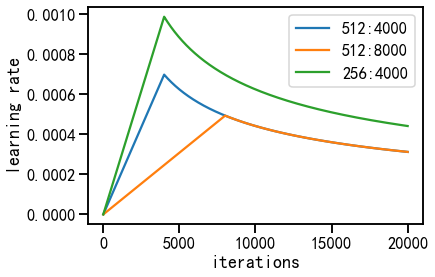

In [49]:
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), 
  [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
plt.xlabel('iterations')
plt.ylabel('learning rate')

# 训练过程

In [50]:
# Train the simple copy task.
V = 11 # here V is the vocab size of source and target languages (sequences)
criterion = LabelSmoothing(size=V, 
    padding_idx=0, smoothing=0.01) # 创建损失函数计算对象
    
model = make_model(V, V, N=2, d_model=8, d_ff=16, h=2) 
# EncoderDecoder对象构造
'''
in make_model: src_vocab_size=11, tgt_vocab_size=11, 
    N=2, d_model=512, d_ff=2048, h=8, dropout=0.1
'''

model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), 
        lr=0, betas=(0.9, 0.98), eps=1e-9))
# 模型最优化算法的对象

lossfun = SimpleLossCompute(model.generator, 
        criterion, model_opt)
if True:
    print ('start model training...')
    for epoch in range(10):
        print ('epoch={}, training...'.format(epoch))
        model.train() # set the model into "train" mode
        # 设置模型进入训练模式
        
        #lossfun = SimpleLossCompute(model.generator, 
        #    criterion, model_opt) # 不需要在这里定义lossfun
        
        run_epoch(epoch, data_gen(V, 4, 2), model, lossfun)
        # 重新构造一批数据，并执行训练
        
        model.eval() # 模型进入evaluation模式 (dropout，反向传播无效）
        print ('evaluating...')
        print(run_epoch(epoch, data_gen(V, 4, 2), model, 
                        SimpleLossCompute(model.generator, 
                        criterion, None)))
        # 这里None表示优化函数为None，所以不进行参数更新 

d:\Anaconda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


start model training...
epoch=0, training...
epoch step: 0:1 Loss: 88.65534043312073/31, tokens per sec: 62/0.28242969512939453
evaluating...
epoch step: 0:1 Loss: 102.32730031013489/35, tokens per sec: 66/0.060967445373535156
tensor(2.8912)
epoch=1, training...
epoch step: 1:1 Loss: 77.49501848220825/31, tokens per sec: 63/0.09920382499694824
evaluating...
epoch step: 1:1 Loss: 84.65634942054749/31, tokens per sec: 64/0.05257558822631836
tensor(2.6950)
epoch=2, training...
epoch step: 2:1 Loss: 90.68220734596252/35, tokens per sec: 69/0.07580423355102539
evaluating...
epoch step: 2:1 Loss: 95.7685604095459/36, tokens per sec: 70/0.04938197135925293
tensor(2.8016)
epoch=3, training...
epoch step: 3:1 Loss: 100.91917181015015/34, tokens per sec: 68/0.07680249214172363
evaluating...
epoch step: 3:1 Loss: 83.68315076828003/34, tokens per sec: 65/0.05086374282836914
tensor(2.7281)
epoch=4, training...
epoch step: 4:1 Loss: 93.78761315345764/33, tokens per sec: 67/0.07280731201171875
evalua

# 测试过程（贪心搜索）

In [54]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask) 
    # 源语言的一个batch
    # 执行encode编码工作，得到memory 
    # shape=(batch.size, src.seq.len, d_model)
    
    # src = (1,4), batch.size=1, seq.len=4
    # src_mask = (1,1,4) with all ones
    # start_symbol=1
    
    print ('memory={}, memory.shape={}'.format(memory, 
        memory.shape))
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    # 最初ys=[[1]], size=(1,1); 这里start_symbol=1
    print ('ys={}, ys.shape={}'.format(ys, ys.shape))
    for i in range(max_len-1): # max_len = 5
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        # memory, (1, 4, 8), 1=batch.size, 4=src.seq.len, 8=d_model
        # src_mask = (1,1,4) with all ones
        # out, (1, 1, 8), 1=batch.size, 1=seq.len, 8=d_model                             
        # print ('out={}, out.shape={}'.format(out, out.shape))
        print('out.shape={}'.format(out.shape))
        prob = model.generator(out[:, -1]) 
        # pick the right-most word
        # (1=batch.size,8) -> generator -> prob=(1,5) 5=trg.vocab.size
        # -1 for ? only look at the final (out) word's vector
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        print('next_word={}'.format(next_word))
        # word id of "next_word"
        ys = torch.cat([ys, 
          torch.ones(1, 1).type_as(src.data).fill_(next_word)], 
          dim=1)
        # ys is in shape of (1,2) now, i.e., 2 words in current seq
    return ys

if True:
    model.eval()
    src = Variable(torch.LongTensor([[1,2,3,4]]))
    src_mask = Variable(torch.ones(1, 1, 4))
    print(greedy_decode(model, src, src_mask, max_len=5, 
        start_symbol=1))


memory=tensor([[[-0.0074, -0.5101,  0.9849,  1.7664,  0.3676, -0.3998, -1.1558,
          -1.0329],
         [-0.1066, -0.4749, -0.6959,  1.8062,  1.3188, -0.7176, -0.2250,
          -0.8860],
         [ 0.2270, -1.0549,  0.5829,  1.4915,  0.6446, -0.4115,  0.1804,
          -1.6517],
         [ 0.1524, -0.9586,  0.1945,  1.6614,  1.0826, -1.3099, -0.1595,
          -0.6519]]], grad_fn=<AddBackward0>), memory.shape=torch.Size([1, 4, 8])
ys=tensor([[1]]), ys.shape=torch.Size([1, 1])
out.shape=torch.Size([1, 1, 8])
next_word=1
out.shape=torch.Size([1, 2, 8])
next_word=1
out.shape=torch.Size([1, 3, 8])
next_word=1
out.shape=torch.Size([1, 4, 8])
next_word=1
tensor([[1, 1, 1, 1, 1]])
